In [1]:
!pip install --upgrade --force-reinstall --no-deps transformers
!pip install --upgrade --force-reinstall --no-deps datasets

!pip install --upgrade --force-reinstall --no-deps huggingface_hub

!pip install --upgrade --force-reinstall --no-deps pyarrow
!pip install --upgrade --force-reinstall --no-deps pyarrow_hotfix

  Obtaining dependency information for transformers from https://files.pythonhosted.org/packages/0a/fd/280f4385e76f3c1890efc15fa93f7206134fefad6351397e1bfab6d0d0de/transformers-4.39.1-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 1.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 35.5 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: transformers
    Found existing installation: transformers 4.36.2
    Uninstalling transformers-4.36.2:
      Successfully uninstalled transformers-4.36.2
  Obtaining dependency information for datasets from https://files.pythonhosted.org/packages/95/fc/661a7f06e8b7d48fcbd3f55423b7ff1ac3ce59526f146fda87a1e1788ee4/datasets-2.18.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 3.5 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: datasets
    Found existing installation: datasets 2.1.0
    Uninstalling datasets-2.1.0:
      Successfully uninstall

In [6]:
from datasets import load_dataset,DatasetDict
from transformers import AutoTokenizer,TFAutoModelForSequenceClassification
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

In [3]:
DATA_PATH = "/kaggle/input/no-hate-transformer/cleaned_data_nosw.csv"

In [14]:
# Load the dataset
df = pd.read_csv(DATA_PATH)

# Convert to string
df['tweet'] = str(df['tweet'])

# Drop every column that isn't tweet or class
df = df.drop(df.columns.difference(['tweet', 'class']), axis=1)

# First, we want to use the tokenizer to tokenize and encode the dataset into embeddings
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

# We will create a small function that will take care of tokenization and encoding
def encode_texts(tokenizer, texts, max_length):
    encoding = tokenizer.batch_encode_plus(
        texts,
        # This is required to add special tokens such as the [CLS] and [SEP] tokens that indicate the start and end of a sentence
        add_special_tokens=True,
        # Here the padding variable is responsible for padding the sequences to the same length
        padding='max_length',
        # The max length of the tokenized sequences
        max_length=max_length,
        return_attention_mask=True,
        # Here we specify that we want the output to be TensorFlow tensors
        return_tensors='tf',
        # If the sequence is longer than max_length, it will be truncated to a fixed length
        truncation=True
    )
    # The encoding['input_ids'] contains the tokenized sequences
    # The encoding['attention_mask'] contains the attention masks and tells the model which tokens to pay attention to and which ones to ignore (mask token)
    return encoding['input_ids'], encoding['attention_mask']

# Here we define the maximum length (randomly chosen per ChatGPT's recommendation)
max_length = 128

# We can then call the function to tokenize and encode the dataset
input_ids, attention_masks = encode_texts(tokenizer, df['tweet'].tolist(), max_length)

# Here we create labels from the 'class' column
# This is the target variable that we want to predict
labels_np = tf.convert_to_tensor(df['class'].values, dtype=tf.int32).numpy()

# For some reason, I was getting an error saying that I needed to convert to NumPy arrays instead of TensorFlow tensors
# So I converted the input_ids and attention_masks to NumPy arrays
input_ids_np = input_ids.numpy()
attention_masks_np = attention_masks.numpy()

# Here we split the data into training, validation, and test sets
train_val_inputs, test_inputs, train_val_labels, test_labels = train_test_split(input_ids_np, labels_np, random_state=2021, test_size=0.1)
train_val_masks, test_masks, _, _ = train_test_split(attention_masks_np, labels_np, random_state=2021, test_size=0.1)

# Here we further split the training set into training and validation sets
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(train_val_inputs, train_val_labels, random_state=2021, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(train_val_masks, train_val_labels, random_state=2021, test_size=0.1)

# Here we create TensorFlow datasets from the NumPy arrays
train_dataset = tf.data.Dataset.from_tensor_slices(((train_inputs, train_masks), train_labels))
validation_dataset = tf.data.Dataset.from_tensor_slices(((validation_inputs, validation_masks), validation_labels))
test_dataset = tf.data.Dataset.from_tensor_slices(((test_inputs, test_masks), test_labels))

# Here we shuffle the training dataset and set the batch size
BUFFER_SIZE = len(train_inputs) 
BATCH_SIZE = 32
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
validation_dataset = validation_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [8]:
text = "Just checking tokenization"

output = tokenizer(text)

output

{'input_ids': [101, 2066, 9444, 22559, 2734, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1]}

In [9]:
tokens = tokenizer.convert_ids_to_tokens(output['input_ids'])
tokens

['[CLS]', 'Just', 'checking', 'token', '##ization', '[SEP]']

In [10]:
print(f"Tokenized text: {tokenizer.convert_tokens_to_string(tokens)}")

Tokenized text: [CLS] Just checking tokenization [SEP]


In [11]:
print(f"Vocab size is : {tokenizer.vocab_size}")

print(f"Model max length is : {tokenizer.model_max_length}")

print(f"Model input names are: {tokenizer.model_input_names}")

Vocab size is : 28996
Model max length is : 512
Model input names are: ['input_ids', 'token_type_ids', 'attention_mask']


In [15]:
model = TFAutoModelForSequenceClassification.from_pretrained("bert-base-cased")

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=tf.metrics.SparseCategoricalAccuracy(),
)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=3)

Epoch 1/3
628/628 [==============================] - 604s 878ms/step - loss: 0.4561 - sparse_categorical_accuracy: 0.8330 - val_loss: 0.4522 - val_sparse_categorical_accuracy: 0.8342
Epoch 2/3
628/628 [==============================] - 548s 872ms/step - loss: 0.4541 - sparse_categorical_accuracy: 0.8331 - val_loss: 0.4568 - val_sparse_categorical_accuracy: 0.8342
Epoch 3/3
628/628 [==============================] - 546s 870ms/step - loss: 0.4550 - sparse_categorical_accuracy: 0.8331 - val_loss: 0.4496 - val_sparse_categorical_accuracy: 0.8342


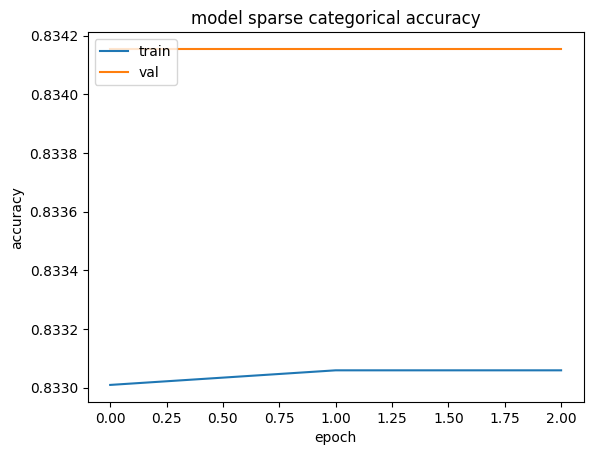

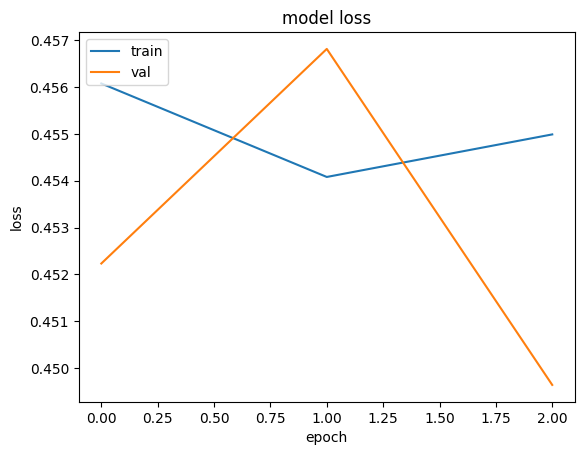

In [17]:
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model sparse categorical accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [18]:
test_loss, test_acc = model.evaluate(test_dataset,verbose=2)
print('\nTest accuracy:', test_acc)

78/78 - 22s - loss: 0.4707 - sparse_categorical_accuracy: 0.8217 - 22s/epoch - 282ms/step

Test accuracy: 0.8217023015022278
